Link for the paper and the github code 

https://www.pnas.org/doi/pdf/10.1073/pnas.1918387117 

https://github.com/annaduncan/Kir_scripts/blob/master/lipid_prot_interaction_frequencies_v5.py


In [1]:
import sys
import re
import numpy as np
import time
import MDAnalysis
from MDAnalysis.analysis.distances import distance_array
import MDAnalysis.lib.NeighborSearch as NS
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cmx
import matplotlib.colors as colors
import mdtraj as md
import ast
import argparse
from tqdm import tqdm
import re
import pandas as pd
import seaborn as sns
import os
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
mpl.rcParams['axes.linewidth'] = 1

sns.set_context("paper", rc={"lines.linewidth": 3},font_scale=1.2)

#from interaction_freq_core import protein_info, get_real_resnums_strlist, bondini_residuesymbol_size, martini_residuesymbol_size

In [2]:
def count_lipids_chains(ref,traj,
                        lipid_str, side,
                        dist_cutoff=7.0,start=1,end=91):
    
    
    r'''
    This function counts the number of lipid around the given cutoff of protein
    
    Parameters
    -----------
    ref : string 
        topology file
    
    traj: string
            Trajectory file
    
    lipid_str: string
                lipid
                
    dist cutoff : float 
                
    
    Returns
    -------
    count : array
           the array having numbers of lipid molecules in a distance

    Tcount : array
            Total number of lipids in the distance cutoff
    '''
    
    
    u     = MDAnalysis.Universe(ref,traj)
    count = []
    Tcount= []
    #start = 1
    #end   = u.select_atoms("protein").resids[-1]
    side  = side


#     if lipid_str=="CD":
#        lipid_str="CD"+"L?"
#        lipid_string="CDL"
       
    print ("Count lipids- the processing lipid is:", lipid_str)
    print ("processing frames are-%s %s:%s:%s"%(lipid_str,start_f,end_f,stride))
    for ts in u.trajectory[start_f:end_f:stride]:
        ts             = ts.frame
        lipid_select   ="byres (resname %s) and (around %s (protein and (resid %s:%s)))" %(lipid_str,
                                                                                          dist_cutoff,
                                                                                          start,end)
                                                                                           
        TLipids_select ="byres (resname POP? CDL CDL2) and (around %s (protein and (resid %s:%s)))" %(dist_cutoff,
                                                                                                  start,end) 

        lipids_sel       = GetCoords(ts, lipid_str, lipid_select,   side=side)
        TotalLipids_sel  = GetCoords(ts, lipid_str, TLipids_select, side=side)
        

        # print ("frames",ts,lipid_str,lipids_sel.resids,np.unique(lipids_sel.resids),
        #        len(np.unique(lipids_sel.resids)))
        
#         print ("frames",ts,lipid_str,np.unique(TotalLipids_sel.resids), 
#                len(np.unique(TotalLipids_sel.resids)))
        
        count.append(len(np.unique(lipids_sel.resids)))
        Tcount.append(len(np.unique(TotalLipids_sel.resids)))
    
 
    np.savetxt('%s_chain_%s_%s-%s.out'%(lipid_str,side, start,end), count, delimiter=',',fmt='%4d') 
    np.savetxt('AllLipid_chain_%s_%s-%s_count.out'%(side,start,end), Tcount, delimiter=',',fmt='%4d') 
    return (count,Tcount)

In [3]:
def GetCoords(ts,lipid,select,side='up',):
    
    r'''
    This function calcultes the mean Z position and return the coordiante based upon selection
    
    Parameters
    -----------
    ts : int
        time step
    
    lipid_select : string 
                   selection string
                    >>> "resname %s and around 7 (protein and resid %s-%s) " %(lipid, 1,176)
    
    side : side of the membrane leaflet
                    >>> up:upper, down:lower, both: up or down
    
    Returns
    -------
    coor : array
          The calculated array satisfying the above condition. 
    '''
    
    
    
    #print ('Frame Coords %i'%(ts))
    u = MDAnalysis.Universe(ref,traj)
    u.trajectory[ts]

    # Select atoms within this particular frame
   
    atoms   = u.select_atoms(select)
    num_atm = atoms.n_atoms
    zmean   = np.mean(atoms.positions[:,2])
    #print (atoms.residues.resids,atoms.residues.resnames,atoms.positions)
    
    coors=[]
    if side == 'up':
        zpos = atoms.positions[:,2] 
        for i in range(num_atm):
            if zpos[i] > zmean:
                coors.append(atoms[i])
        coors = np.sum(np.array(coors))
        
    if side == 'down':
        zpos = atoms.positions[:,2] 
        for i in range(num_atm):
            if zpos[i] < zmean:
                coors.append(atoms[i])
        coors = np.sum(np.array(coors))
        
    if side == 'both':
        zpos = atoms.positions[:,2]
        for i in range(num_atm):
            coors.append(atoms[i])
        coors = np.sum(np.array(coors))
        
        
    return coors 

In [4]:
from re import split


def plot_lipid_counts_chain(lipid_selection,side,start,end):
    
    r'''
    This function plots the % number of a lipid in a cutoff

    $\%Number = \frac{lipid_{x}}{Total-lipid_{x}}*100

    Parameters
    -----------
    
    lipid_select : string 
                   selection string
                    >>> "resname %s and around 7 (protein and resid %s-%s) " %(lipid, 1,176)
    
    side : side of the membrane leaflet
                    >>> up:upper, down:lower, both: up or down
    
    '''
    fig, ax = plt.subplots()
    
    #file='AllLipid_chain_%s_count.out'%(side)
    if os.path.isfile('AllLipid_chain_%s_%s-%s_count.out'%(side,start,end)):  
        df1=pd.read_csv('AllLipid_chain_%s_%s-%s_count.out'%(side,start,end),header=None,names=['TotalLipidNumber'])
        #print (df1)
    else:
        print ("Error: 'AllLipid_chain_%s_%s-%s_count.out'%(side,start,end) file exists")
    
    
    df =pd.read_csv('%s_chain_%s_%s-%s.out'%(lipid_selection,side, start,end),header=None,names=['LipidNumber'])

    df['Time']       =np.arange(len(df))
    df['Time']       = df['Time']/10
    df['LipidNumber']=(df['LipidNumber']/df1['TotalLipidNumber'])*100
    
    mean=df['LipidNumber'].mean()
   #print (mean)
   
    edge_colors = ['orange','blue','darkgrey']
    sys_colors = {'POPC':'#1e90ff', 
                  'POPE':'#ff69b4', 
                  'POPG':'#8040bf', 
                  'CDL2':'#00fa9a'}
    
    for k,v in sys_colors.items(): 
        if str(lipid_selection) in k:
            print (lipid_selection,v)

            g=sns.lineplot(x='Time', y='LipidNumber', data=df, label=lipid_selection,color=v)
            ax.xaxis.set_minor_locator(MultipleLocator(5))
            ax.yaxis.set_minor_locator(MultipleLocator(2.5))
            ax.yaxis.set_major_locator(MultipleLocator(5))
            g.axhline(mean,ls='--',c='k')

            plt.legend(loc=2, frameon=False)
            plt.ylim(bottom=0)
            plt.xlabel("Time (μs)",fontsize=14)
            plt.ylabel("Number (%)",fontsize=14)
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            plt.tight_layout()
            plt.savefig('%s_chain_%s_%s-%s_count.png'%(lipid_selection,side,start,end), dpi=600, bbox_inches='tight')
            plt.show()


/home/nyadav/anaconda3/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/nyadav/anaconda3/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/nyadav/anaconda3/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: R
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/nyadav/anaconda3/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: T
  warnings.warn("Failed to guess the mass for the following atom types: {}".for

number of frames process= 166
Count lipids- the processing lipid is: POPG
processing frames are-POPG 0:16535:100
POPG #8040bf


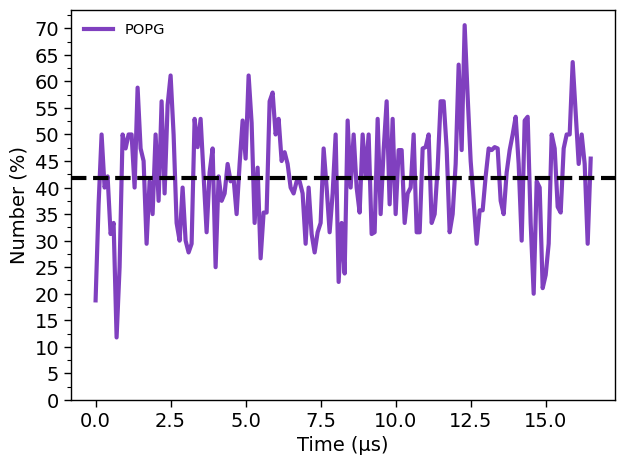

/home/nyadav/anaconda3/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/nyadav/anaconda3/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/nyadav/anaconda3/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: R
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/nyadav/anaconda3/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: T
  warnings.warn("Failed to guess the mass for the following atom types: {}".for

Count lipids- the processing lipid is: POPC
processing frames are-POPC 0:16535:100
POPC #1e90ff


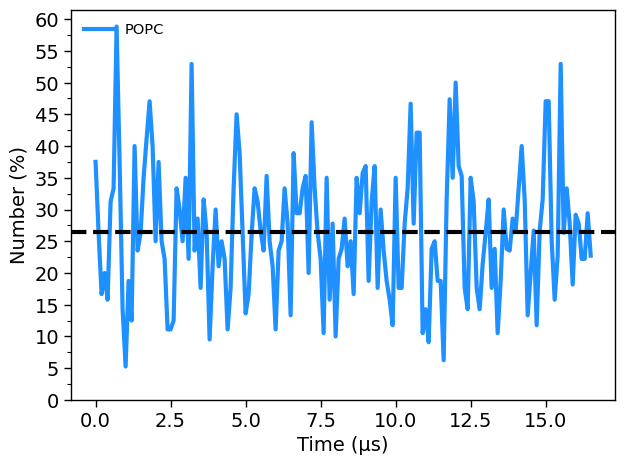

/home/nyadav/anaconda3/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/nyadav/anaconda3/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/nyadav/anaconda3/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: R
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/nyadav/anaconda3/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: T
  warnings.warn("Failed to guess the mass for the following atom types: {}".for

Count lipids- the processing lipid is: POPE
processing frames are-POPE 0:16535:100


/home/nyadav/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nyadav/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


AttributeError: 'numpy.float64' object has no attribute 'resids'

In [5]:
if __name__ == "__main__":
    
    ref               = "../LH1RC_RoseoDenit_CG_Run1_npt.gro"
    traj              = "../LH1RC_RoseoDenit_CG_Run1_prod.xtc"    
    u                 = MDAnalysis.Universe(ref,traj)
    
    start_f           = 0
    end_f             = len(u.trajectory)
    stride            = 100
    n_frames          = np.arange(start_f, end_f)[::stride]
    protein_centre_cutoff =50.0
    
    print ("number of frames process=",len(n_frames))
    NumProt           = u.select_atoms("protein").resids[-1]
    dist_cutoff       = 10.0  #prot-lipid interaction distance cut-off    
    cutoff_value      = 70.0 #prot-lipid interacting above the Interaction_cutoff in the distance of dist_cutoff
    
    start             = 274
    end               = 364
    
    lipid_particles = {'headgroup' :{ 
                   'POPG' : ['PO4','GL0'],
                   'POPC' : ['PO4','NC3'],
                   'POPE' : ['PO4','NH3'],
                   'CDL2' : ['PO41','GL0'],
                   'CDL'  : ['PO41','GL0']},
                'phosphate' : {
                    'POPG' : ['PO4'],
                    'POPC' : ['PO4'],
                    'POPE' : ['PO4'],
                    'CDL2' : ['PO41'],
                    'CDL'  : ['PO41']},
                 'numbers' :{
                     'POPG' : ['252'],
                     'POPC' : ['362'],
                     'POPE' : ['331'],
                     'CDL2' : ['56'],
                     'CDL'  : ['8']} }
    
    lip   =['POPG', 'POPC', 'POPE', 'CDL', 'CDL2']
    sides =['up', 'down', 'both'] # to chose the side of the leaflet
    




    #function call 
    #the function to count the numbers of lipids around protein
    for side in range(0,len(sides)-1):
        side=sides[side]
        for i in range(0,len(lip)):
            aa = ' '.join(str(x) for x in lipid_particles['phosphate'][lip[i]])
            #num= ' '.join(str(x) for x in lipid_particles['numbers'][lip[i]])
            #print("resname %s and name %s"%(lip[i],aa))
            #print("byres (resname %s and around %s protein)"%(lip[i],dist_cutoff))
            count,Tcount= count_lipids_chains(ref,traj,lip[i],side='both', dist_cutoff=dist_cutoff,start=start,end=end)
            plot_lipid_counts_chain(lip[i],side='both',start=start,end=end)